# Base loads

In [1]:
!pip install pyro-ppl==1.3.0

     |████████████████████████████████| 501kB 6.5MB/s 


In [2]:
!nvidia-smi

Sun Jun 14 12:17:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import folium
import datetime

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual


import numpy as np
import folium
from folium import plugins
import matplotlib
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Load Git code

In [5]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling, normalizing_flow_factory, conditional_normalizing_flow_factory
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples, searchlog_semisup_day_split, circle_transform, get_split_idx_on_day
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, approx_rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

from DEwNF.utils import calculate_cap_of_model
from DEwNF.utils import calculate_cap_of_hubs
from DEwNF.utils import calculate_cap_of_random
from DEwNF.utils import calculate_cap_of_perfect_model

In [0]:
def AUC_of_CAPS(caps_arr, step_size):
    return np.array(caps_arr).sum() * step_size

# Create results plot for the three different kinds of flows

In [0]:
results_path = os.path.join(root_path, "results/donkey_republic/last_results/results/last")

In [10]:
os.listdir(results_path)

['run1', 'run2']

In [0]:
loaded_dicts = {}

folders = os.listdir(results_path)
for run_name in folders:
    run_path = folder = os.path.join(results_path, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['run2', 'run3']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

In [12]:
loaded_dicts['run2']['planar.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 5,
 'c_net_h_dim': 24,
 'clipped_adam': 10.0,
 'context_cols': ['hour_sin', 'hour_cos', 'rain'],
 'context_dim': 3,
 'context_n_depth': 5,
 'context_n_h_dim': 24,
 'epochs': 1500,
 'flow_depth': 24,
 'initial_lr': 0.0001,
 'l2_reg': None,
 'lr_factor': 0.1,
 'lr_patience': 50,
 'min_lr': 1e-06,
 'obs_cols': ['user_location_latitude', 'user_location_longitude'],
 'problem_dim': 2,
 'rich_context_dim': 6,
 'semisup_context_cols': ['hour_sin', 'hour_cos'],
 'sup_context_context_cols': ['rain']}

In [13]:
loaded_dicts['run2']['combi.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 5,
 'c_net_h_dim': 24,
 'clipped_adam': 10.0,
 'context_cols': ['hour_sin', 'hour_cos', 'rain'],
 'context_dim': 3,
 'context_n_depth': 5,
 'context_n_h_dim': 24,
 'epochs': 1500,
 'flow_depth': 24,
 'initial_lr': 0.0001,
 'l2_reg': None,
 'lr_factor': 0.1,
 'lr_patience': 50,
 'min_lr': 1e-06,
 'obs_cols': ['user_location_latitude', 'user_location_longitude'],
 'problem_dim': 2,
 'rich_context_dim': 6,
 'semisup_context_cols': ['hour_sin', 'hour_cos'],
 'sup_context_context_cols': ['rain']}

In [14]:
loaded_dicts['run2']['affine_coupling.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 5,
 'c_net_h_dim': 24,
 'clipped_adam': 10.0,
 'context_cols': ['hour_sin', 'hour_cos', 'rain'],
 'context_dim': 3,
 'context_n_depth': 5,
 'context_n_h_dim': 24,
 'epochs': 1500,
 'flow_depth': 24,
 'initial_lr': 0.0001,
 'l2_reg': None,
 'lr_factor': 0.1,
 'lr_patience': 50,
 'min_lr': 1e-06,
 'obs_cols': ['user_location_latitude', 'user_location_longitude'],
 'problem_dim': 2,
 'rich_context_dim': 6,
 'semisup_context_cols': ['hour_sin', 'hour_cos'],
 'sup_context_context_cols': ['rain']}

In [15]:
runs

['run1', 'run2']

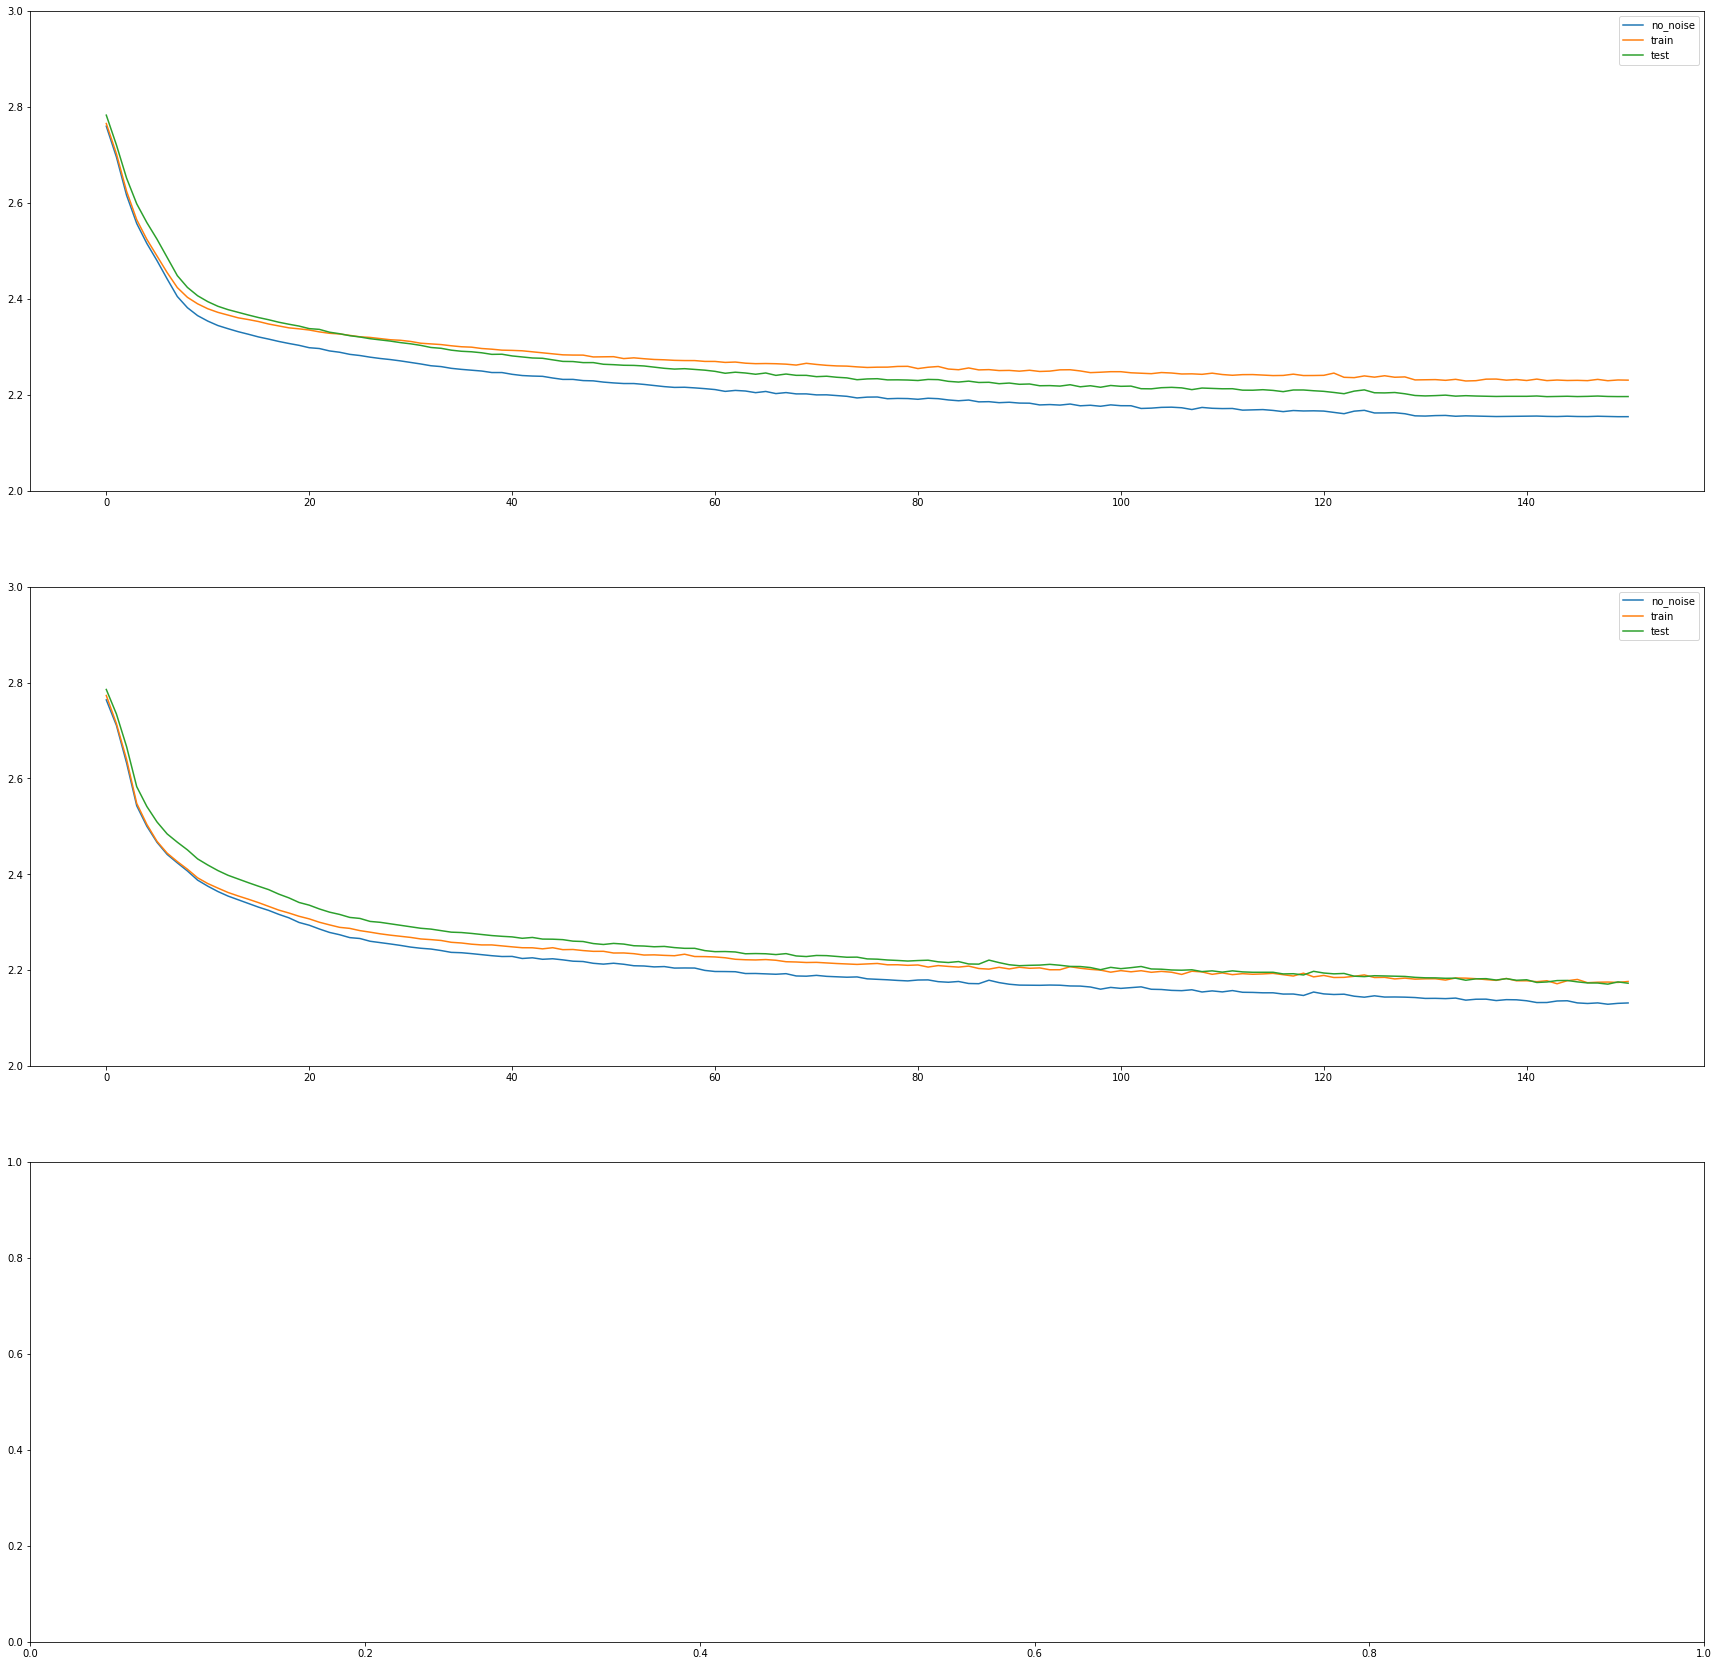

In [16]:
fig, ax = plt.subplots(3, figsize=(30,30))
for i, run in enumerate(runs):
    ax[i].set_ylim((2,3))
    ax[i].plot(loaded_dicts[run]['affine_coupling.pickle']['logs']['no_noise_losses'])
    ax[i].plot(loaded_dicts[run]['affine_coupling.pickle']['logs']['train'])
    ax[i].plot(loaded_dicts[run]['affine_coupling.pickle']['logs']['test'])
    ax[i].legend(['no_noise', 'train', 'test'])

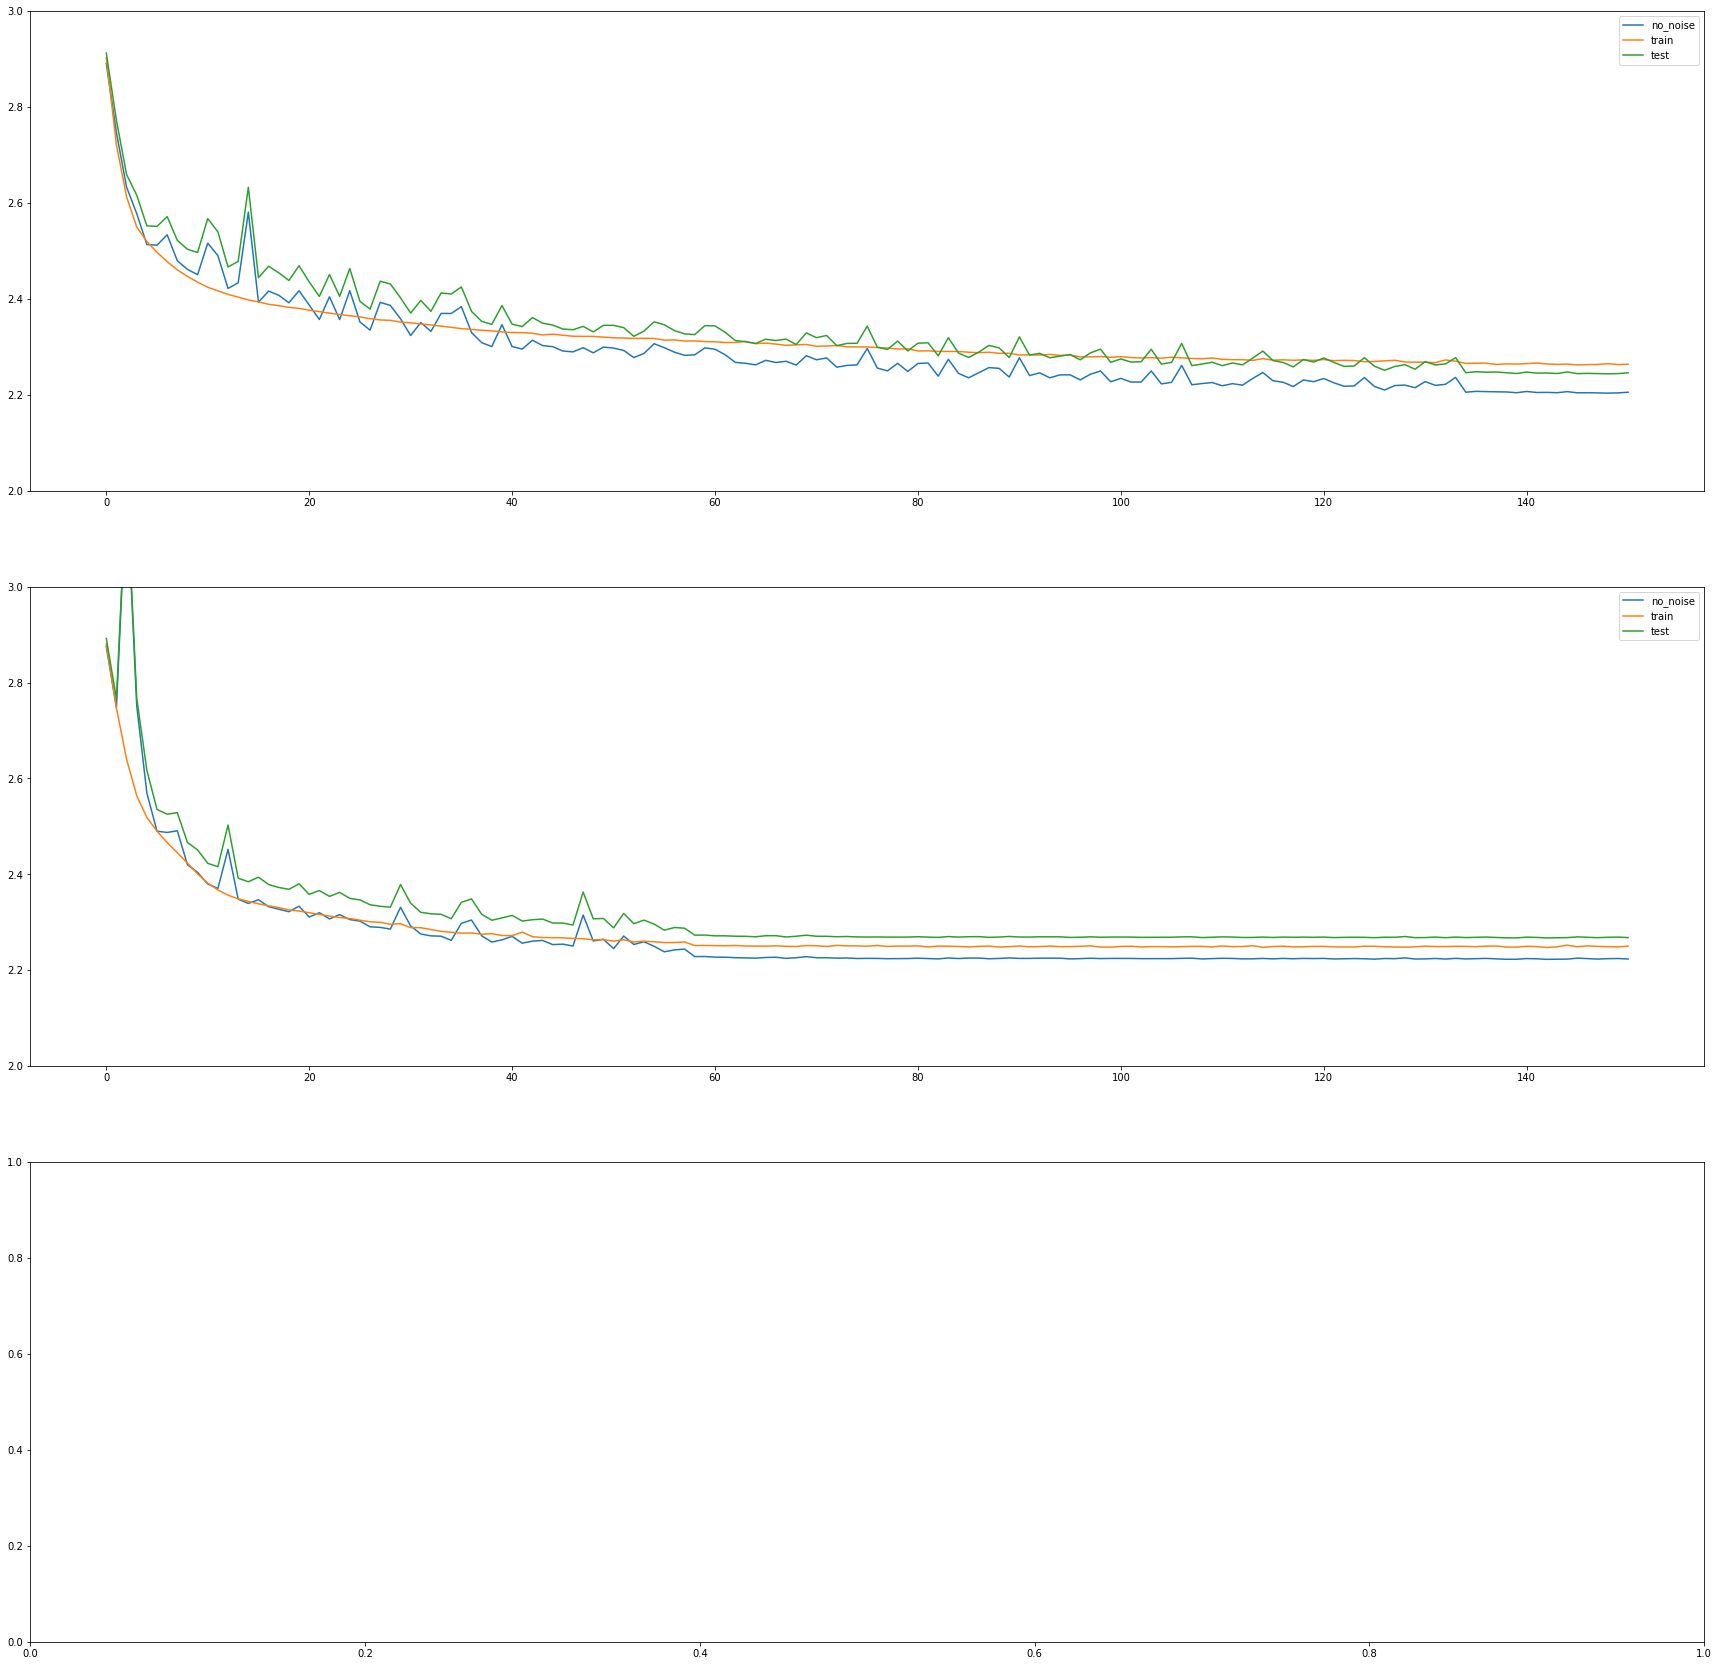

In [17]:
fig, ax = plt.subplots(3, figsize=(30,30))
for i, run in enumerate(runs):
    ax[i].set_ylim((2,3))
    ax[i].plot(loaded_dicts[run]['combi.pickle']['logs']['no_noise_losses'])
    ax[i].plot(loaded_dicts[run]['combi.pickle']['logs']['train'])
    ax[i].plot(loaded_dicts[run]['combi.pickle']['logs']['test'])
    ax[i].legend(['no_noise', 'train', 'test'])

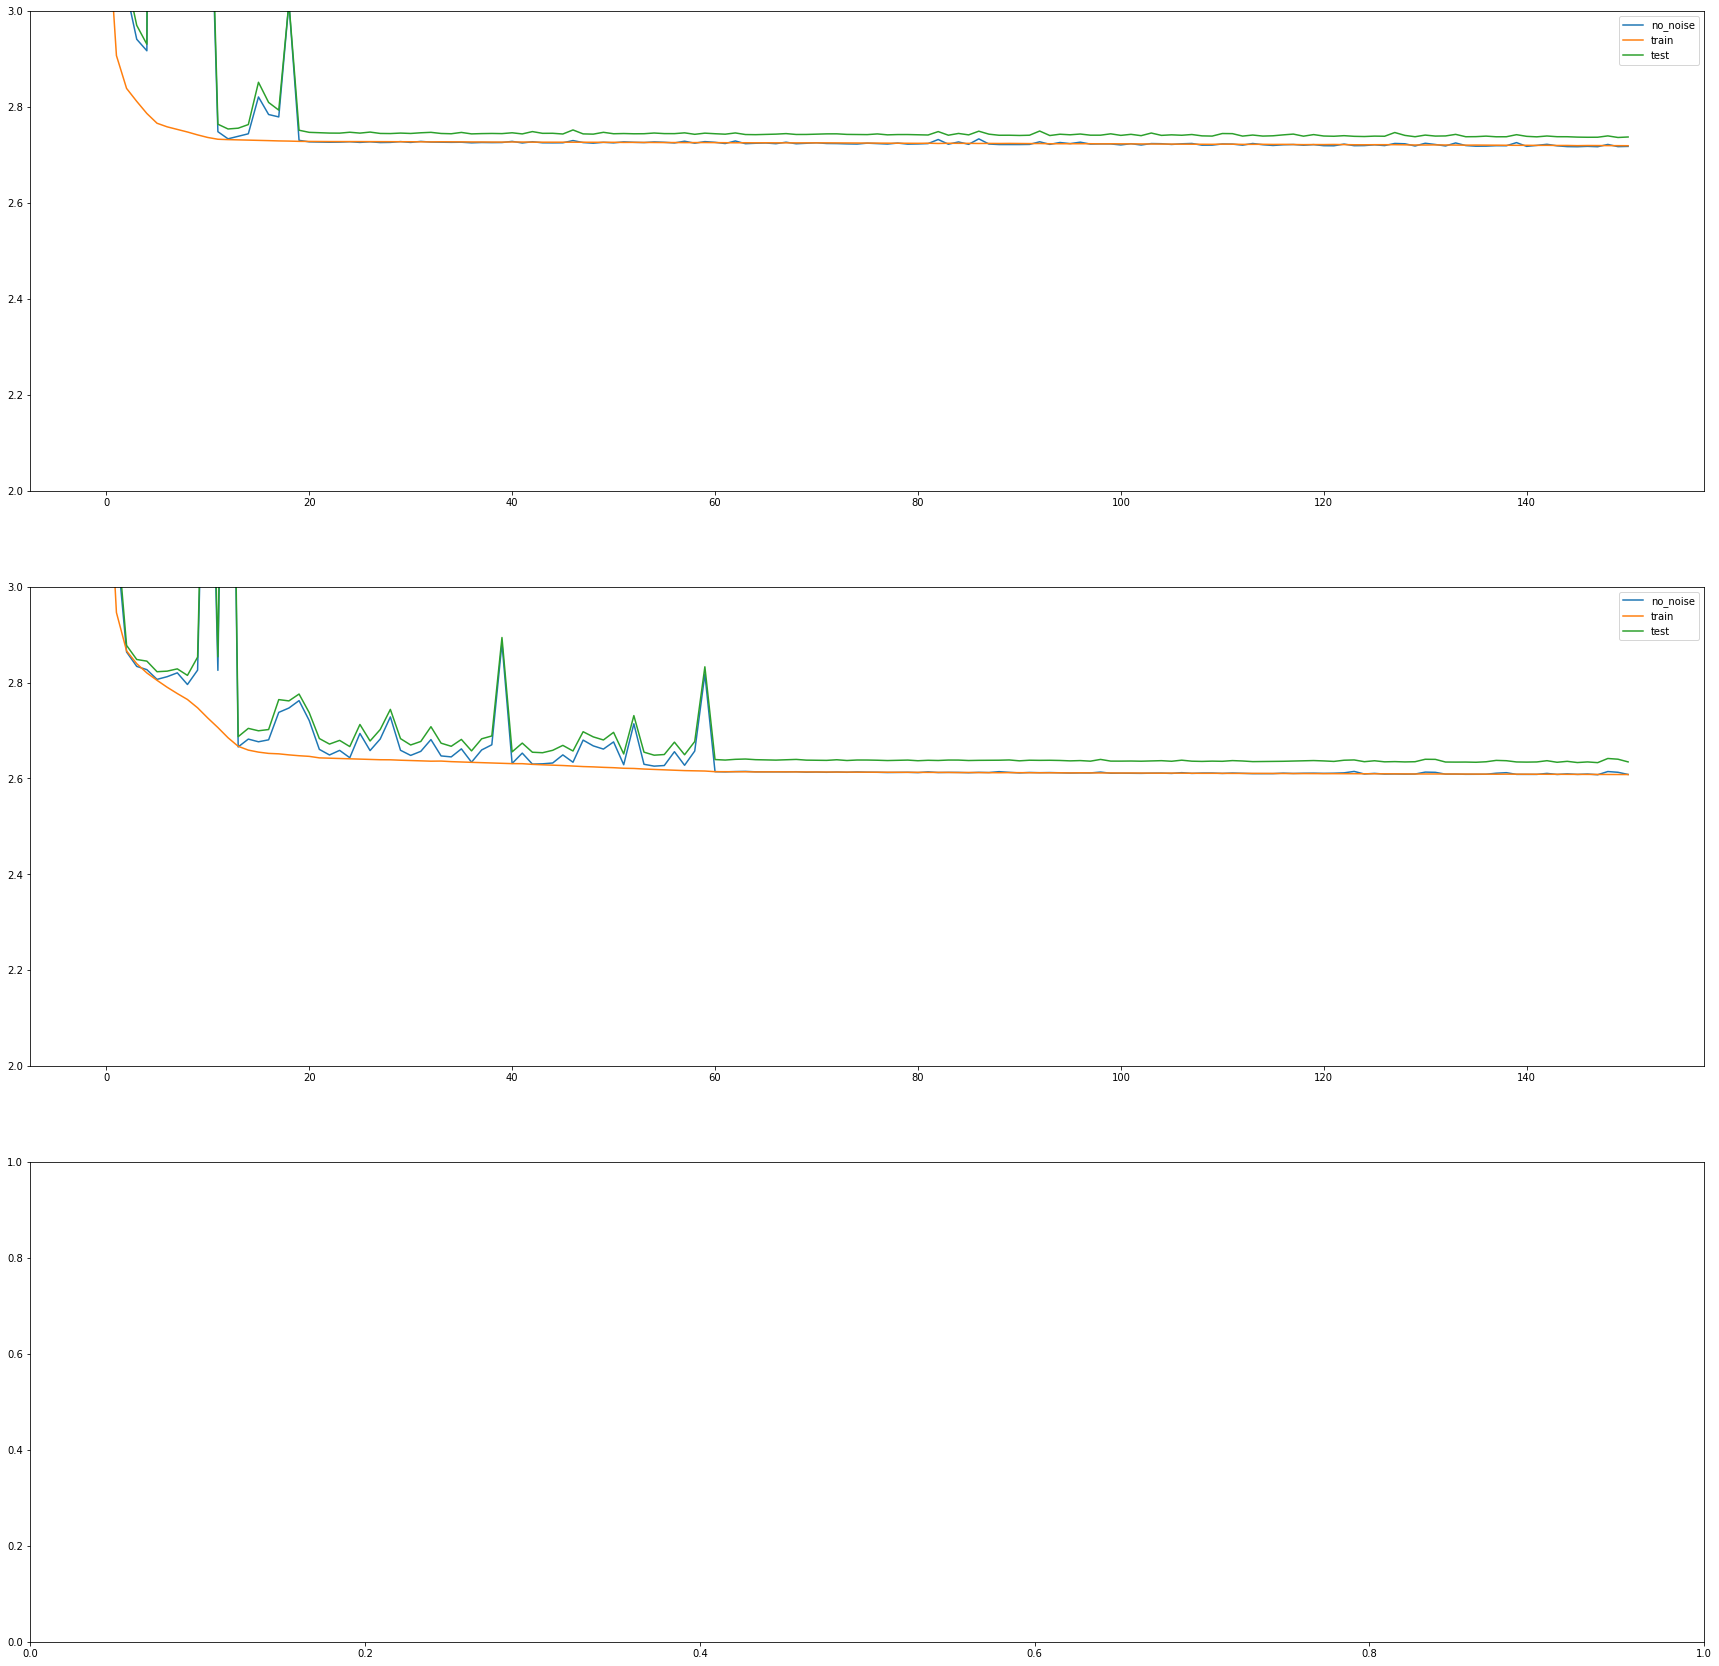

In [18]:
fig, ax = plt.subplots(3, figsize=(30,30))
for i, run in enumerate(runs):
    ax[i].set_ylim((2,3))
    ax[i].plot(loaded_dicts[run]['planar.pickle']['logs']['no_noise_losses'])
    ax[i].plot(loaded_dicts[run]['planar.pickle']['logs']['train'])
    ax[i].plot(loaded_dicts[run]['planar.pickle']['logs']['test'])
    ax[i].legend(['no_noise', 'train', 'test'])

In [0]:
models = ['affine_coupling.pickle', 'planar.pickle', 'combi.pickle']
means = -np.array([results_dict[model]['mean'] for model in models])
mins = -np.array([results_dict[model]['min'] for model in models])
maxs = -np.array([results_dict[model]['max'] for model in models])
model_names = [model.split('.')[0] for model in models]
upper_err = maxs - means
lower_err = means - mins

In [20]:
results_dict

{'affine_coupling.pickle': {'max': 2.1961767537196146,
  'mean': 2.1846067664675886,
  'min': 2.173036779215563},
 'combi.pickle': {'max': 2.2681987155979324,
  'mean': 2.2568686805846605,
  'min': 2.2455386455713886},
 'planar.pickle': {'max': 2.737332191691115,
  'mean': 2.6858988904460044,
  'min': 2.634465589200894}}

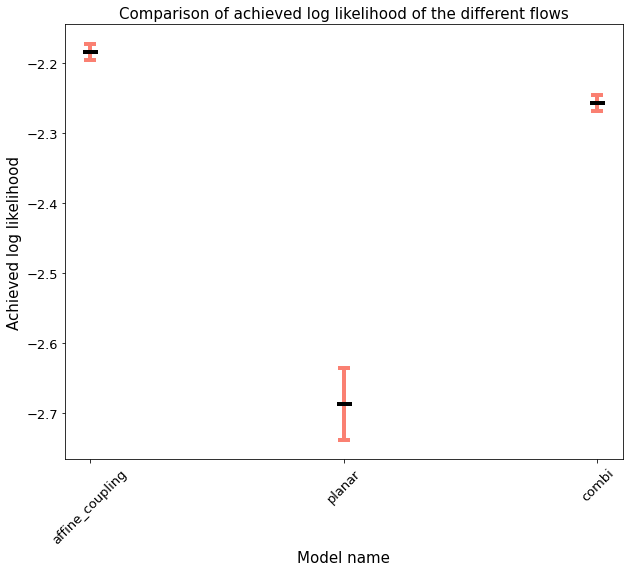

In [21]:
plt.figure(figsize=(10,8))
plt.errorbar(model_names, means, yerr=[lower_err, upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='salmon'
                )
plt.title("Comparison of achieved log likelihood of the different flows", fontsize=15)
plt.xticks(model_names, model_names, rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Model name', fontsize=15)
plt.ylabel('Achieved log likelihood', fontsize=15)
plt.show()

In [22]:
model_names

['affine_coupling', 'planar', 'combi']

In [0]:
def return_model_names(model_name_arr):
    model_names = []
    for model in model_name_arr:
        if model == 'affine_coupling':
            model_names.append('Affine Coupling')

        if model == 'planar':
            model_names.append('Planar')

        if model == 'combi':
            model_names.append('Mixed')
            
    return model_names

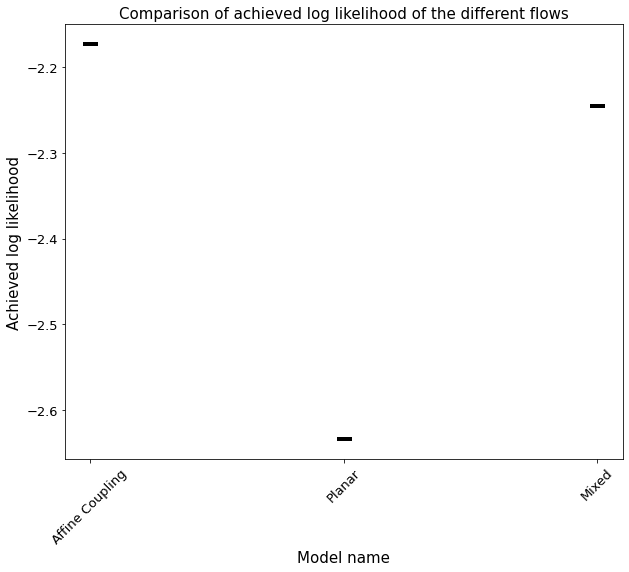

In [24]:
plt.figure(figsize=(10,8))
plt.errorbar(model_names, mins,
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='salmon'
                )
plt.title("Comparison of achieved log likelihood of the different flows", fontsize=15)
plt.xticks(model_names, return_model_names(model_names), rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Model name', fontsize=15)
plt.ylabel('Achieved log likelihood', fontsize=15)
plt.show()

# CAP Comparison

## Load datasets

In [0]:
donkey_folder = os.path.join(dataset_folder, 'Donkey_republic')
csv_path = os.path.join(donkey_folder, 'CoordinateSearchlog_simple.csv')
donkey_df = pd.read_csv(csv_path, parse_dates=[4, 11])


In [0]:
hubs_path = os.path.join(donkey_folder, "Hubs.csv")
hubs_df = pd.read_csv(hubs_path, parse_dates=[0])
hubs_df['deleted'] = ~hubs_df.deleted_at.isnull()


In [0]:
extra_path = os.path.join(donkey_folder, 'UnsupervisedCoordinateSearchlog.csv')
extra_df = pd.read_csv(extra_path, parse_dates=[4,12])

In [0]:
hubs_ranking_path = os.path.join(donkey_folder, 'HubsRankedByRentals.csv')
ranked_hubs_df = pd.read_csv(hubs_ranking_path, index_col=0)


## Load models

In [29]:
results_dict

{'affine_coupling.pickle': {'max': 2.1961767537196146,
  'mean': 2.1846067664675886,
  'min': 2.173036779215563},
 'combi.pickle': {'max': 2.2681987155979324,
  'mean': 2.2568686805846605,
  'min': 2.2455386455713886},
 'planar.pickle': {'max': 2.737332191691115,
  'mean': 2.6858988904460044,
  'min': 2.634465589200894}}

In [0]:
affine_coupling_flow = loaded_dicts['run2']['affine_coupling.pickle']['model']
planar_flow = loaded_dicts['run2']['planar.pickle']['model']
combi_flow = loaded_dicts['run2']['combi.pickle']['model']

In [0]:
obs_cols = loaded_dicts['run2']['affine_coupling.pickle']['settings']['obs_cols']

weather_semisup_context_cols = loaded_dicts['run2']['affine_coupling.pickle']['settings']['semisup_context_cols']
weather_sup_context_cols = loaded_dicts['run2']['affine_coupling.pickle']['settings']['sup_context_context_cols']

no_weather_semisup_context_cols = loaded_dicts['run2']['affine_coupling.pickle']['settings']['semisup_context_cols']
batch_size = loaded_dicts['run2']['affine_coupling.pickle']['settings']['batch_size']

## CAP no rain

In [0]:
train_idx, test_idx = get_split_idx_on_day(donkey_df)

In [0]:
train_dataloader, test_dataloader, extra_dataloader, obs_scaler, semisup_context_scaler, sup_context_scaler = searchlog_semisup_day_split(sup_df=donkey_df,
                                                                                                                                          unsup_df=extra_df,
                                                                                                                                          obs_cols=obs_cols,
                                                                                                                                          semisup_context_cols=weather_semisup_context_cols,
                                                                                                                                          sup_context_cols=weather_sup_context_cols,
                                                                                                                                          batch_size=batch_size,
                                                                                                                                          cuda_exp=True)

In [34]:
no_weather_semisup_context_cols

['hour_sin', 'hour_cos']

In [0]:
hour_test = 8
rain = False

hour_cos, hour_sin = circle_transform(hour_test,24)
scaled_context_no_weather = semisup_context_scaler.transform([[hour_sin, hour_cos]])
scaled_context_w_weather = np.array([np.concatenate((scaled_context_no_weather[0], [rain]))])

In [0]:
test_df = donkey_df.loc[test_idx]
context_idx = (test_df.merge_date.dt.hour == hour_test) & (test_df.rain == rain)
context_filtered_df = test_df.loc[context_idx]

In [37]:
len(context_filtered_df)

4303

In [0]:
# Map settings
initial_location = [55.6775757, 12.579571639999999]
hub_map = folium.Map(width=500,height=500,location=initial_location, zoom_start=12)
lower_left = [55.578855, 12.368879]
upper_right = [55.785292, 12.746675]
bounds = [lower_left, upper_right]


# Condition conditional flows
conditioned_affine_coupling_flow = affine_coupling_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())
conditioned_planar_flow = planar_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())
conditioned_combi_flow = combi_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())

In [39]:
# Affine coupling flow
_, _, _, affine_coupling_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_affine_coupling_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [02:37, 253.93it/s]


In [40]:
# planar flow
_, _, _, planar_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_planar_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [02:37, 253.22it/s]


In [41]:
# combi flow
_, _, _, combi_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_combi_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [02:36, 254.93it/s]


In [42]:
# perfect model
_, _, perfect_covered_arr = calculate_cap_of_perfect_model(shape = (200,200), bounds=bounds, df=context_filtered_df)

40000it [02:44, 243.45it/s]
40000it [00:04, 9490.39it/s]


In [43]:
# CAP of donkey hubs
_, _, _, hubs_covered_arr = calculate_cap_of_hubs(shape=(200,200), bounds=bounds, logs_df=context_filtered_df, hubs_df=hubs_df, ranked_hubs_df=ranked_hubs_df)

1203it [00:04, 252.40it/s]


In [44]:
# CAP of random model
_, _, _, random_percent_covered_arr = calculate_cap_of_random(shape=(200,200), bounds=bounds, dist=conditioned_planar_flow, df=context_filtered_df, obs_scaler=obs_scaler) # note dist not actually used here just copy pasted code

40000it [04:00, 166.65it/s]


In [0]:
n_hubs = len(hubs_covered_arr)

Text(0, 0.5, 'Fraction of logs covered')

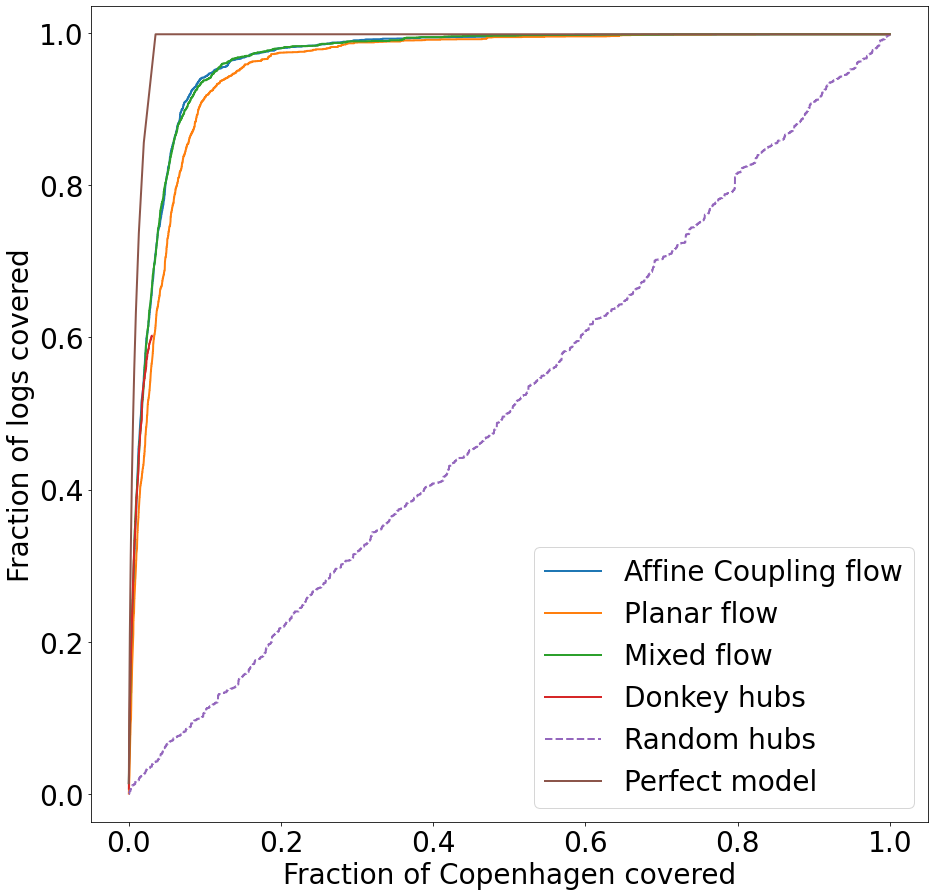

In [63]:
plt.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')

ax.plot(x, affine_coupling_covered_arr, linewidth=2)
ax.plot(x, planar_covered_arr, linewidth=2)
ax.plot(x, combi_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x, random_percent_covered_arr, '--', linewidth=2)
ax.plot(x, perfect_covered_arr, linewidth=2)
ax.legend(['Affine Coupling flow', 'Planar flow', 'Mixed flow', 'Donkey hubs', 'Random hubs', 'Perfect model'], loc='lower right', markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered')
ax.set_ylabel('Fraction of logs covered')

Text(0, 0.5, 'Fraction of logs covered')

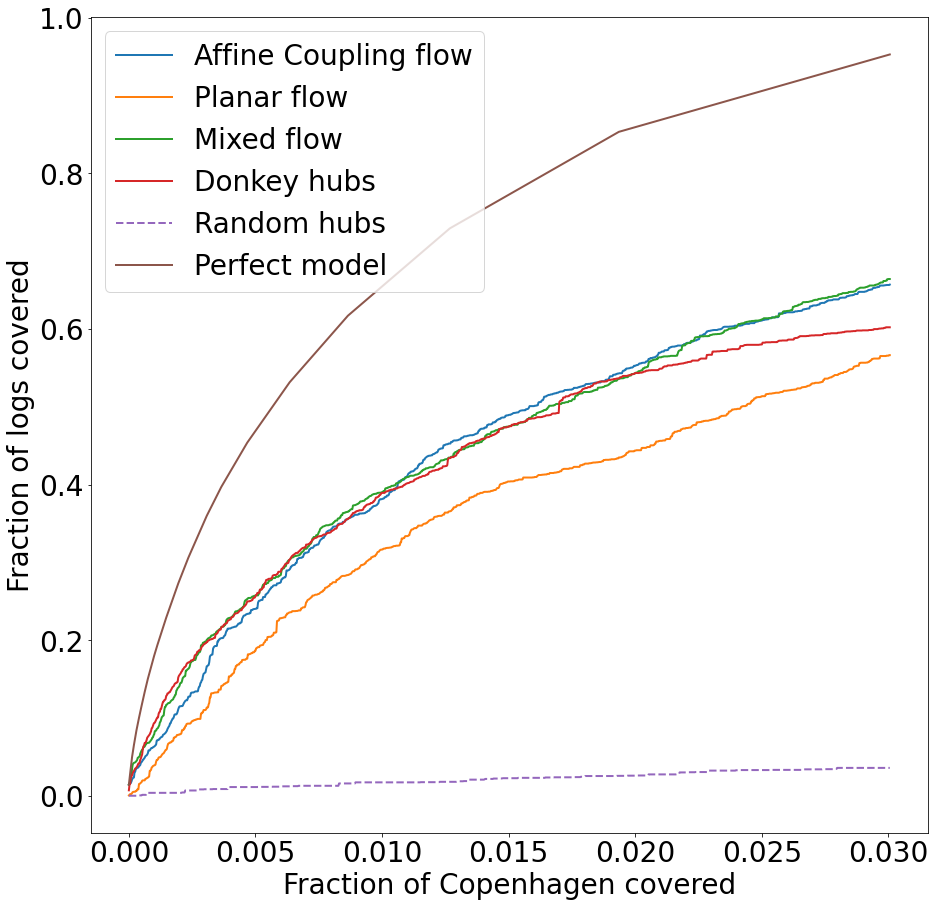

In [66]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(x[:n_hubs], affine_coupling_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], planar_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], combi_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], random_percent_covered_arr[:n_hubs], '--', linewidth=2)
ax.plot(x[:n_hubs], perfect_covered_arr[:n_hubs], linewidth=2)
ax.legend(['Affine Coupling flow', 'Planar flow', 'Mixed flow', 'Donkey hubs', 'Random hubs', 'Perfect model'], loc='upper left', markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered')
ax.set_ylabel('Fraction of logs covered')

#### Calculate AUC full CAP

In [0]:
step_size = x[1] - x[0]

In [49]:
# Affine coupling
AUC_of_CAPS(affine_coupling_covered_arr, step_size)

0.9657634422501279

In [50]:
# Planar
AUC_of_CAPS(planar_covered_arr, step_size)

0.9556172322853272

In [51]:
# Mixed
AUC_of_CAPS(combi_covered_arr, step_size)

0.9657556393592619

In [52]:
# Random
AUC_of_CAPS(random_percent_covered_arr, step_size)

0.5075510341163131

In [53]:
# Perfect
AUC_of_CAPS(perfect_covered_arr, step_size)

0.9894116688264637

#### Calculate AUC part CAP

In [54]:
# Affine coupling
AUC_of_CAPS(affine_coupling_covered_arr[:n_hubs], step_size)

0.013254369239779447

In [55]:
# Planar
AUC_of_CAPS(planar_covered_arr[:n_hubs], step_size)

0.010794186889299237

In [56]:
# Mixed
AUC_of_CAPS(combi_covered_arr[:n_hubs], step_size)

0.013320696717162295

In [57]:
# Random
AUC_of_CAPS(random_percent_covered_arr[:n_hubs], step_size)

0.0006409119093884854

In [58]:
# Perfect
AUC_of_CAPS(perfect_covered_arr[:n_hubs], step_size)

0.02115133635951868

In [0]:
# Hubs
AUC_of_CAPS(hubs_covered_arr, step_size)

## CAP rain

In [0]:
train_idx, test_idx = get_split_idx_on_day(donkey_df)

In [0]:
train_dataloader, test_dataloader, extra_dataloader, obs_scaler, semisup_context_scaler, sup_context_scaler = searchlog_semisup_day_split(sup_df=donkey_df,
                                                                                                                                          unsup_df=extra_df,
                                                                                                                                          obs_cols=obs_cols,
                                                                                                                                          semisup_context_cols=weather_semisup_context_cols,
                                                                                                                                          sup_context_cols=weather_sup_context_cols,
                                                                                                                                          batch_size=batch_size,
                                                                                                                                          cuda_exp=True)

In [69]:
no_weather_semisup_context_cols

['hour_sin', 'hour_cos']

In [0]:
hour_test = 8
rain = True

hour_cos, hour_sin = circle_transform(hour_test,24)
scaled_context_no_weather = semisup_context_scaler.transform([[hour_sin, hour_cos]])
scaled_context_w_weather = np.array([np.concatenate((scaled_context_no_weather[0], [rain]))])

In [0]:
test_df = donkey_df.loc[test_idx]
context_idx = (test_df.merge_date.dt.hour == hour_test) & (test_df.rain == rain)
context_filtered_df = test_df.loc[context_idx]

In [72]:
len(context_filtered_df)

432

In [0]:
# Map settings
initial_location = [55.6775757, 12.579571639999999]
hub_map = folium.Map(width=500,height=500,location=initial_location, zoom_start=12)
lower_left = [55.578855, 12.368879]
upper_right = [55.785292, 12.746675]
bounds = [lower_left, upper_right]


# Condition conditional flows
conditioned_affine_coupling_flow = affine_coupling_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())
conditioned_planar_flow = planar_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())
conditioned_combi_flow = combi_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())

In [74]:
# Affine coupling flow
_, _, _, affine_coupling_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_affine_coupling_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [02:35, 257.05it/s]


In [75]:
# planar flow
_, _, _, planar_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_planar_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [02:36, 255.63it/s]


In [76]:
# combi flow
_, _, _, combi_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_combi_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [02:35, 256.90it/s]


In [77]:
_, _, _, hubs_covered_arr = calculate_cap_of_hubs(shape=(200,200), bounds=bounds, logs_df=context_filtered_df, hubs_df=hubs_df, ranked_hubs_df=ranked_hubs_df)

1203it [00:04, 248.92it/s]


In [78]:
_, _, _, random_percent_covered_arr = calculate_cap_of_random(shape=(200,200), bounds=bounds, dist=conditioned_planar_flow, df=context_filtered_df, obs_scaler=obs_scaler) # note dist not actually used here just copy pasted code

40000it [03:58, 167.63it/s]


In [79]:
# perfect model
_, _, perfect_covered_arr = calculate_cap_of_perfect_model(shape = (200,200), bounds=bounds, df=context_filtered_df)

40000it [02:42, 246.42it/s]
40000it [00:04, 9473.48it/s]


In [0]:
n_hubs = len(hubs_covered_arr)

Text(0, 0.5, 'Fraction of logs covered')

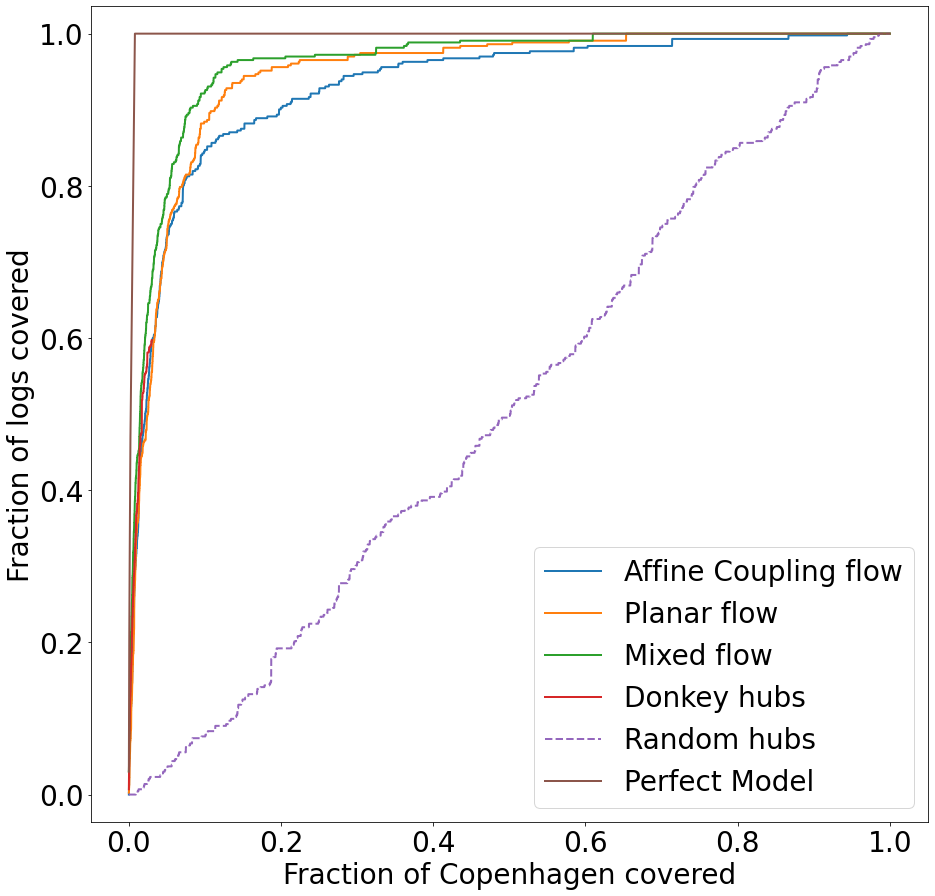

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')

ax.plot(x, affine_coupling_covered_arr, linewidth=2)
ax.plot(x, planar_covered_arr, linewidth=2)
ax.plot(x, combi_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x, random_percent_covered_arr, '--', linewidth=2)
ax.plot(x, perfect_covered_arr, linewidth=2)
ax.legend(['Affine Coupling flow', 'Planar flow', 'Mixed flow', 'Donkey hubs', 'Random hubs', 'Perfect Model'], loc='lower right', markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered')
ax.set_ylabel('Fraction of logs covered')

Text(0, 0.5, 'Fraction of logs covered')

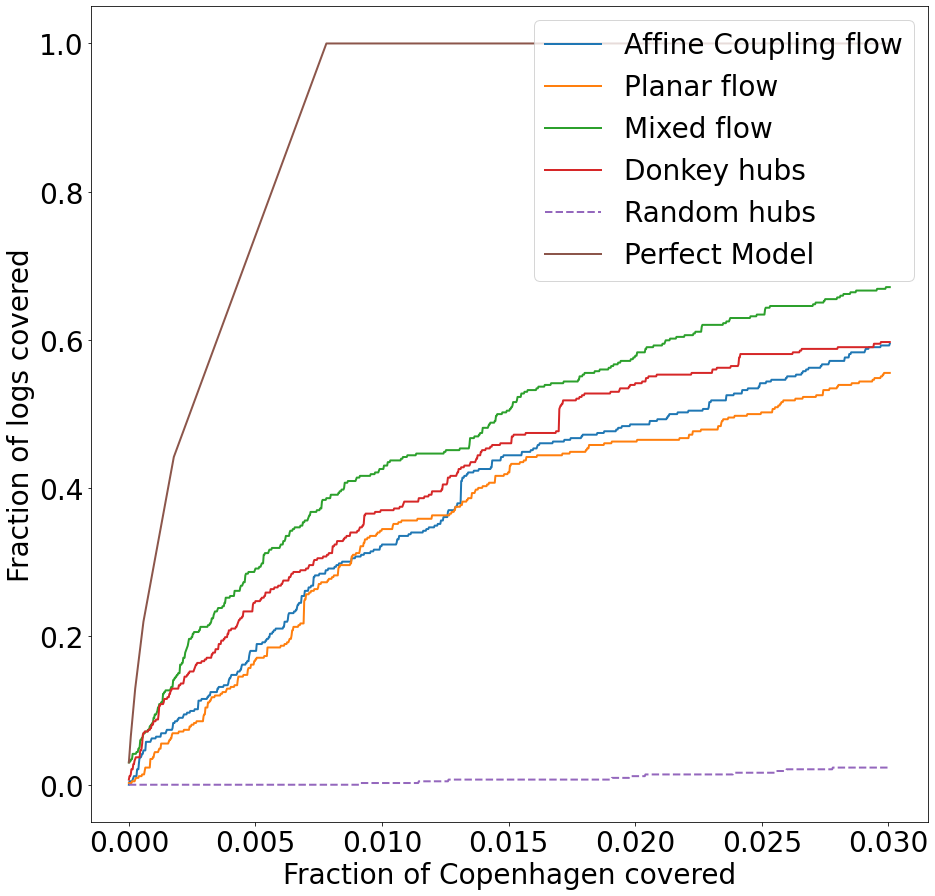

In [85]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(x[:n_hubs], affine_coupling_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], planar_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], combi_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], random_percent_covered_arr[:n_hubs], '--', linewidth=2)
ax.plot(x[:n_hubs], perfect_covered_arr[:n_hubs], linewidth=2)
ax.legend(['Affine Coupling flow', 'Planar flow', 'Mixed flow', 'Donkey hubs', 'Random hubs', 'Perfect Model'], loc='upper right', markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered')
ax.set_ylabel('Fraction of logs covered')

#### Calculate AUC full CAP

In [0]:
step_size = x[1] - x[0]

In [0]:
# Affine coupling
AUC_of_CAPS(affine_coupling_covered_arr, step_size)

In [0]:
# Planar
AUC_of_CAPS(planar_covered_arr, step_size)

In [0]:
# Mixed
AUC_of_CAPS(combi_covered_arr, step_size)

In [0]:
# Random
AUC_of_CAPS(random_percent_covered_arr, step_size)

In [0]:
# Perfect
AUC_of_CAPS(perfect_covered_arr, step_size)

#### Calculate AUC part CAP

In [0]:
# Affine coupling
AUC_of_CAPS(affine_coupling_covered_arr[:n_hubs], step_size)

In [0]:
# Planar
AUC_of_CAPS(planar_covered_arr[:n_hubs], step_size)

In [0]:
# Mixed
AUC_of_CAPS(combi_covered_arr[:n_hubs], step_size)

In [0]:
# Random
AUC_of_CAPS(random_percent_covered_arr[:n_hubs], step_size)

In [0]:
# Perfect
AUC_of_CAPS(perfect_covered_arr[:n_hubs], step_size)

In [0]:
# Hubs
AUC_of_CAPS(hubs_covered_arr, step_size)